# Transfer learning(전이학습)
- fine tuning

- 개와 고양이 분류를, 이미 잘 만들어진 뉴널네트워크를 활용하여, 성능을 올려보자.

![alt text](https://live.staticflickr.com/4544/38228876666_3782386ca7_b.jpg)



- tensorflow 사전학습모델
    - https://www.tensorflow.org/api_docs/python/tf/keras/applications?hl=ko

- 모바일넷버전2 사용
    - https://www.tensorflow.org/api_docs/python/tf/keras/applications/MobileNetV2?_gl=1*146h9uh*_up*MQ..*_ga*MTg3MjU5ODYzOS4xNzU3NTcxODIx*_ga_W0YLR4190T*czE3NTc1NzE4MjAkbzEkZzAkdDE3NTc1NzE4MjAkajYwJGwwJGgw

- https://www.researchgate.net/figure/The-proposed-MobileNetV2-network-architecture_fig1_350152088

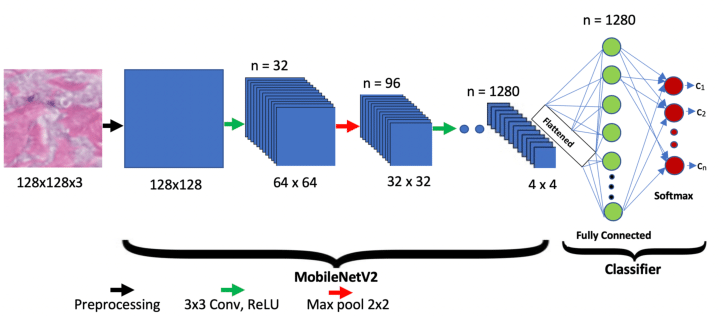

- 전이학습(Transfer Learning)
    - 똑똑한 사람이 만들어 놓을 것을 가져가서 쓰는것
    - imagenet 데이터를 학습한 것을 사용함.
    - ms coco image 데이터도 있음.
    - 사전학습된 모델 :  base(CNN 부분) + head(ANN 부분)
    - base(특징 추출을 잘함)는 그대로 쓰고, head 부분을 재구성함.

# Transfer learning - Finetuning
- 세밀한 튜닝을 하겠다는 뜻을 하면 잘됨

## 필요한 라이브러리 로딩

In [1]:
import os, zipfile, pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Step1: Downloading the Dogs vs Cats dataset 

## 데이터 준비
- 데이터가 있다면 실행 안해도 됨

In [2]:
# 압축을 풀 위치
extract_root = pathlib.Path("./datas_dnn")

In [3]:
import gdown  
# 데이터의 위치
url = "https://drive.google.com/uc?id=1wr4e_7P2d4ICN11ecNb8aqhbakD4ahK6"
file_id = "1wr4e_7P2d4ICN11ecNb8aqhbakD4ahK6"
output = "datas_dnn/cats_and_dogs_filtered.zip" # 저장 위치 및 저장할 파일 이름
zip_path = gdown.download(id=file_id, output=output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1wr4e_7P2d4ICN11ecNb8aqhbakD4ahK6
From (redirected): https://drive.google.com/uc?id=1wr4e_7P2d4ICN11ecNb8aqhbakD4ahK6&confirm=t&uuid=84d3241e-6cda-4ae7-b23e-42e36d604c3c
To: E:\magpia000_gg_drive\KPMG_FA7th_lab_prepare\5DNN_ex\datas_dnn\cats_and_dogs_filtered.zip
100%|████████████████████████████████████████████████████████████████| 69.4M/69.4M [00:06<00:00, 10.3MB/s]


In [4]:
# 압축풀기
with zipfile.ZipFile(zip_path, 'r') as zip_file:
    zip_file.extractall(extract_root)

### Import project dependencies

In [3]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Step 2: Dataset preprocessing

In [6]:
BASE_DIR = extract_root / 'cats_and_dogs_filtered'
train_dir  = BASE_DIR / 'train'
val_dir = BASE_DIR / 'validation'

In [7]:
IMG_SIZE = 128  # 모바일넷 모델 이미지 기준
IMAGE_SHAPE= (IMG_SIZE, IMG_SIZE, 3)
BATCH_SIZE = 128
SEED = 1337

In [8]:
train_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    image_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    shuffle=True,
    seed = SEED
 )

Found 2000 files belonging to 2 classes.


In [9]:
val_ds = keras.utils.image_dataset_from_directory(
    val_dir,
    image_size = (IMG_SIZE, IMG_SIZE) ,
    batch_size = BATCH_SIZE,
    shuffle=True,
)

Found 1000 files belonging to 2 classes.


In [10]:
class_names = train_ds.class_names

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

In [12]:
train_ds = train_ds.prefetch(AUTOTUNE)

In [13]:
val_ds = val_ds.prefetch(AUTOTUNE)

In [14]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomTranslation(0.1, 0.1)
    ],
    name = 'data_augmentation'
)

# Step3: Building the model : MobileNetV2 를 활용

## Loading the pre-trained model (MobileNetV2)

모바일이나, 임베디드에서도 실시간을 작동할 수 있게 모델이 경량화 되면서도, 정확도 또한 많이 떨어지지 않게하여, 속도와 정확도 사이의 트레이드 오프 문제를 어느정도 해결한 네트워크 입니다.

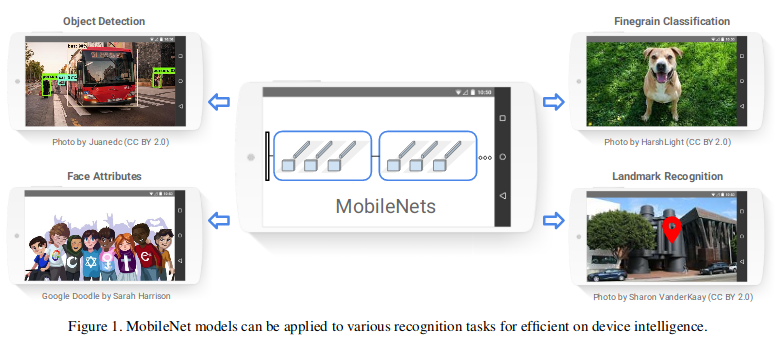

### 1) 사전학습 모델 불러오기

In [15]:
# 사전학습된 모델 : base(CNN 부분) + head(ANN 부분)
# include_top=False : 분류기(FC layer) 제거, CNN의 feature extractor 부분만 사용
base_model = MobileNetV2(input_shape=IMAGE_SHAPE, include_top=False, weights='imagenet')

### 2) Freezing the base model

In [16]:
# 사전학습된 가중치를 그대로 사용하고, 학습 동안 업데이트하지 않겠다
base_model.trainable = False

### 3) 모델의 head 부분 새롭게 정의

#### Defining the model

- functional API 라는 방식으로 트랜스퍼 러닝을 구성함

In [17]:
# 데이터 입력층 정의
inputs = keras.Input(shape=IMAGE_SHAPE)

In [18]:
# 데이터 증강 해라
x = data_augmentation(inputs)

In [19]:
# 리스케일링(모바일넷 학습할때, 이렇게 했다고함.) 
# 이건 메뉴얼에 나와 있는내용, 이렇게 했을 떄 학습이 잘된다고 함.
x = layers.Rescaling(scale=1.0/127.5, offset=-1.0)(x)

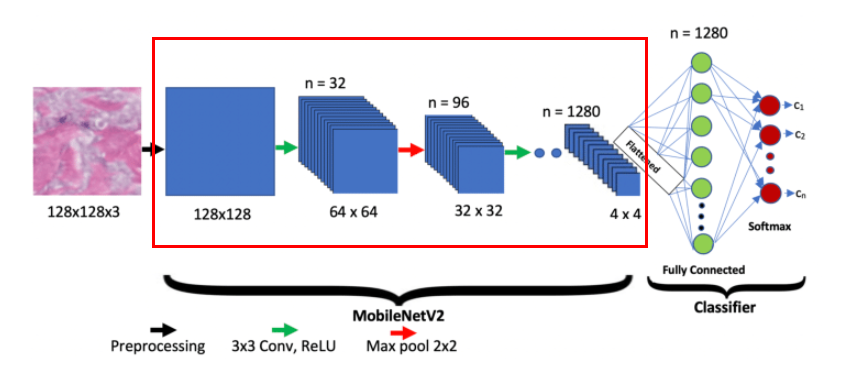
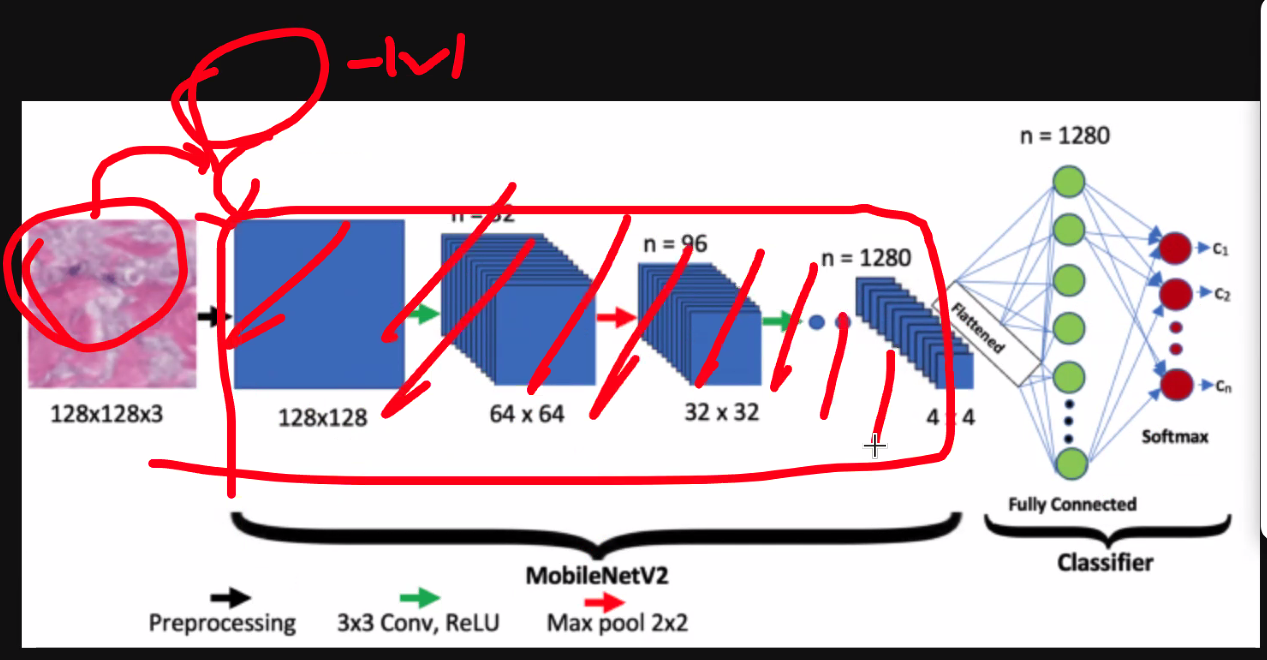

- base 모델 통과됨

In [20]:
# 베이스 모델에 전처리한 데이터 넣기
# training=False :해당 모델을 학습 모드가 아니라, 예측(inference) 모드로 실행
x = base_model(x, training=True)

In [21]:
# base_model.layers

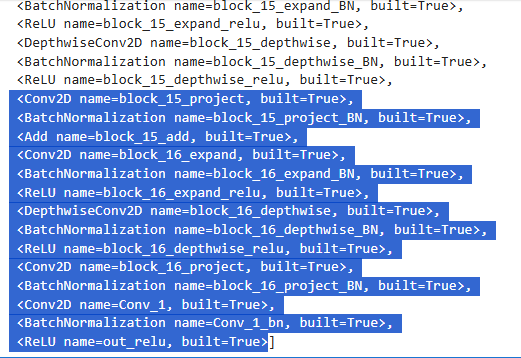

In [22]:
# 뒷부분 14개 층만 파인튜닝, base 앞쪽은 안함
for layer in base_model.layers[:-14]:
    layer.trainable = False

In [23]:
# 평균을 flattern과 동일함 (각행렬의 대표값하나를 뽑음)
# FC층에 전달하기 전 가장 많이 쓰는 "특징 요약" 방식.
# MobileNetV2 전이학습 구조
# CNN → GlobalAveragePooling2D → FC
# flattern을 사용해도 됨
x = layers.GlobalAveragePooling2D()(x)

In [24]:
# fully connection 층
x = layers.Dense(128, keras.activations.relu)(x)

In [25]:
# 출력층
# outputs = layers.Dense(1, keras.activations.sigmoid)(x)
outputs = layers.Dense(2, activation='softmax')(x)

In [26]:
# 모델 만들기
model = keras.Model(inputs, outputs)

In [27]:
# base_model.summary()

In [28]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_128 (Functional)    │ (None, 4, 4, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### 4) Compiling the model
- 현업에서 일반적으로 전이학습시 러닝레이트를  0.0001~0.001 을 많이 사용함.

In [29]:
# 출력층 sigmoid 인경우
# model.compile(optimizer=keras.optimizers.RMSprop(
#             learning_rate=1e-4),
#             loss=keras.losses.BinaryCrossentropy(),
#             metrics = [ keras.metrics.BinaryAccuracy ])

In [30]:
# softmax 일경우 꼭 해주기
from tensorflow.keras import optimizers, losses, metrics

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=[metrics.SparseCategoricalAccuracy()]
)

### 5) Training the model

In [31]:
history = model.fit(train_ds, epochs=5, validation_data=val_ds)

Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - loss: 0.5354 - sparse_categorical_accuracy: 0.7345 - val_loss: 0.2978 - val_sparse_categorical_accuracy: 0.8880
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - loss: 0.2801 - sparse_categorical_accuracy: 0.8900 - val_loss: 0.1708 - val_sparse_categorical_accuracy: 0.9490
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - loss: 0.2119 - sparse_categorical_accuracy: 0.9120 - val_loss: 0.1363 - val_sparse_categorical_accuracy: 0.9540
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - loss: 0.1817 - sparse_categorical_accuracy: 0.9260 - val_loss: 0.1084 - val_sparse_categorical_accuracy: 0.9640
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - loss: 0.1766 - sparse_categorical_accuracy: 0.9305 - val_loss: 0.0980 - val_sparse_categorical_accuracy: 0.9650


### 6) Transfer learning model evaluation

In [32]:
model.evaluate(val_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 653ms/step - loss: 0.0980 - sparse_categorical_accuracy: 0.9650


[0.09796367585659027, 0.9649999737739563]

### Creating Data Generators

- Resizing images
    - Big pre-trained architecture support only certain input sizes.
    - For example: MobileNet (architecture that we use) supports: (96, 96), (128, 128), (160, 160), (192, 192), (224, 224).

# 모델 일반화

In [33]:
# # === 1) Google Colab에서 이미지 업로드 → 예측 ===
# from google.colab import files
# uploaded = files.upload()  # 파일 선택 → 업로드

# import numpy as np
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras.utils import load_img, img_to_array
# from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# # 업로드한 모든 파일에 대해 예측
# for fname in uploaded.keys():
#     # 1) 이미지 로드 & 리사이즈 & RGB
#     img = load_img(fname, target_size=(IMG_SIZE, IMG_SIZE), color_mode="rgb")
#     x = img_to_array(img)            # (H,W,C)
#     x = np.expand_dims(x, axis=0)    # (1,H,W,C)
#     x = preprocess_input(x)          # MobileNetV2: [-1,1] 스케일

#     # 2) 예측 (이진 분류: 1 유닛 시그모이드 → '개' 확률로 가정)
#     prob_dog = float(model.predict(x, verbose=0)[0][0])
#     pred = "dog" if prob_dog >= 0.5 else "cat"
#     print(f"{fname} -> prob_dog={prob_dog:.4f}  pred={pred}")

In [34]:
import tkinter as tk
from tkinter import filedialog
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# 1) 파일 선택 다이얼로그 열기
root = tk.Tk()
root.withdraw()  # GUI 창 숨기기
file_paths = filedialog.askopenfilenames(title="이미지 파일 선택", 
                                         filetypes=[("Image files", "*.jpg;*.jpeg;*.png")])

# 2) 선택한 파일들 예측
for fname in file_paths:
    img = load_img(fname, target_size=(IMG_SIZE, IMG_SIZE), color_mode="rgb")
    x = img_to_array(img)            # (H,W,C)
    x = np.expand_dims(x, axis=0)    # (1,H,W,C)
    x = preprocess_input(x)          # MobileNetV2: [-1,1] 스케일

    probs = model.predict(x, verbose=0)[0]     # shape = (2,)
    pred_index = np.argmax(probs)
    pred_class = class_names[pred_index]
    pred_prob = probs[pred_index]

    fname = fname.split("/")[-1]
    print(f"{fname} -> class={pred_class}, prob={pred_prob:.4f}, full_probs={probs}")


YellowLabradorLooking_new.jpg -> class=cats, prob=0.7076, full_probs=[0.707624   0.29237604]


In [35]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# 직접 파일 경로 지정
file_paths = [
    r"./datas_dnn/dog.jpg",
    r"./datas_dnn/cat.jpg",
    "./datas_dnn/YellowLabradorLooking_new.jpg",    
]

for fname in file_paths:
    img = load_img(fname, target_size=(IMG_SIZE, IMG_SIZE), color_mode="rgb")
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    probs = model.predict(x, verbose=0)[0]     # shape = (2,)
    pred_index = np.argmax(probs)
    pred_class = class_names[pred_index]
    pred_prob = probs[pred_index]

    fname = fname.split("/")[-1]
    print(f"{fname} -> class={pred_class}, prob={pred_prob:.4f}, full_probs={probs}")

dog.jpg -> class=cats, prob=0.7074, full_probs=[0.70744735 0.29255268]
cat.jpg -> class=cats, prob=0.6965, full_probs=[0.6965003  0.30349967]
YellowLabradorLooking_new.jpg -> class=cats, prob=0.7076, full_probs=[0.707624   0.29237604]


# 수고했습니다.^^